In [ ]:
# @title # **SET UP**
# @markdown The data may take some time to load in, so feel free to move on to the next part in the meantime.

project = "histology"

import requests
from IPython.display import Markdown, display

import tensorflow_datasets as tfds
from tensorflow.image import resize_with_pad, ResizeMethod
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv3D, Flatten
from keras.applications import MobileNetV2, VGG16, VGG19, EfficientNetB0
from keras import Model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import urllib.request
from pathlib import Path

from PIL import Image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def ConfusionMatrix(y_true, y_pred):
  sns.heatmap(pd.crosstab(y_pred, y_true), annot=True)
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.xticks(rotation=45)
  plt.yticks(rotation=45)
  plt.show()

def ProjectDescription(project):
  display_str =  f"**[{project.capitalize()} Project Background Document]({article_url_dict[project]})** <br />"
  display_str += f"**[{project.capitalize()} Dataset Documentation]({dataset_documentation_url_dict[project]})** <br />"
  display(Markdown(display_str))
  response = requests.get(image_url_dict[project], stream=True)
  img = Image.open(response.raw)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

def plot_metric(history, metric="accuracy", best_is_max=True, start_epoch=0, random_model_metric=None):
  # Get lists of accuracies over the epochs
  training_accuracy = history.history[metric][start_epoch:]
  validation_accuracy = history.history['val_' + metric][start_epoch:]

  # Find best epoch depending on whether max is the best for the metric
  if best_is_max:
    best_epoch = validation_accuracy.index(max(validation_accuracy))
  else:
    best_epoch = validation_accuracy.index(min(validation_accuracy))

  # Plot labels
  plt.title(metric.capitalize() + ' as Model Trains')
  plt.xlabel('Epoch #')
  plt.ylabel(metric.capitalize())

  # Plot lines
  plt.plot(training_accuracy, label='Train')
  plt.plot(validation_accuracy, label='Validation')
  plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best Epoch')

  if random_model_metric is not None:
    plt.axhline(random_model_metric, linestyle='--',color='red', label='Chance')

  # Plot legend and show
  plt.legend()
  plt.show()

def download_data(project, download_url_prefix_dict):
    """Download data files if they don't already exist locally.
    
    Args:
        project: Project name (e.g., 'histology')
        download_url_prefix_dict: Dictionary mapping project names to download URLs
        
    Returns:
        Tuple of (images_path, labels_path) as strings
    """
    data_dir = Path("data")
    data_dir.mkdir(exist_ok=True)
    
    images_path = data_dir / "images.npy"
    labels_path = data_dir / "labels.npy"
    
    if images_path.exists() and labels_path.exists():
        print("Data files already exist, skipping download...")
        return str(images_path), str(labels_path)
    
    base_url = download_url_prefix_dict[project]
    images_url = base_url + "images.npy"
    labels_url = base_url + "labels.npy"
    
    print(f"Downloading images from {images_url}...")
    print("This may take a few minutes (~500MB)...")
    urllib.request.urlretrieve(images_url, images_path)
    print(f"Downloading labels from {labels_url}...")
    urllib.request.urlretrieve(labels_url, labels_path)
    print("Download complete!")
    
    return str(images_path), str(labels_path)

# URL dictionaries for the projects
article_url_dict = {
    "beans"     : "https://docs.google.com/document/d/19AcNUO-9F4E9Jtc4bvFslGhyuM5pLxjCqKYV3rUaiCc/edit?usp=sharing",
    "malaria"   : "https://docs.google.com/document/d/1u_iX2oDrEZ1clhFefpP3V8uwAjf7EUV4G6kq_3JDcVY/edit?usp=sharing",
    "histology" : "https://docs.google.com/document/d/162WhUE9KqCgq_I7-VvENZD2n1IVsbeXVRSwfJEkxAqQ/edit?usp=sharing",
    "bees"      : "https://docs.google.com/document/d/1PUB_JuYHi6zyHsWAhkIb7D7ExeB1EfI09arc6Ad1bUY/edit?usp=sharing"
}

image_url_dict = {
    "beans"     : "https://storage.googleapis.com/tfds-data/visualization/fig/beans-0.1.0.png",
    "malaria"   : "https://storage.googleapis.com/tfds-data/visualization/fig/malaria-1.0.0.png",
    "histology" : "https://storage.googleapis.com/tfds-data/visualization/fig/colorectal_histology-2.0.0.png",
    "bees"      : "https://storage.googleapis.com/tfds-data/visualization/fig/bee_dataset-bee_dataset_300-1.0.0.png"
}

download_url_prefix_dict = {
    "histology" : "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Towards%20Precision%20Medicine/",
    "bees"      : "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Safeguarding%20Bee%20Health/"
}

dataset_documentation_url_dict = {
    "beans"     : "https://www.tensorflow.org/datasets/catalog/beans",
    "malaria"   : "https://www.tensorflow.org/datasets/catalog/malaria",
    "bees"      : "https://www.tensorflow.org/datasets/catalog/bee_dataset",
    "histology" : "https://www.tensorflow.org/datasets/catalog/colorectal_histology",
}

# Load dataset
if project == "Choose your dataset!":
  print("Please choose your dataset from the dropdown menu!")

elif project == "beans":
  data,  info = tfds.load('beans', split='train[:1024]', as_supervised=True, with_info=True)
  feature_dict = info.features['label'].names
  images = np.array([resize_with_pad(image, 128, 128, antialias=True) for image,_ in data]).astype(int)
  labels = [feature_dict[int(label)] for image,label in data]

elif project == "malaria":
  data,  info = tfds.load('malaria', split='train[:1024]', as_supervised=True, with_info=True)
  images = np.array([resize_with_pad(image, 256, 256, antialias=True) for image,_ in data]).astype(np.uint8)
  labels = ['malaria' if label==1 else 'healthy' for image,label in data]

else:
  images_path, labels_path = download_data(project, download_url_prefix_dict)
  images = np.load(images_path)
  labels = np.load(labels_path)

#Making the model

# Using the get_dummies() function to one-hot encode your labels.
labels_ohe = np.array(pd.get_dummies(labels))

# Select your feature (X) and labels (y).
y = labels_ohe
X = images

# Split your data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Initialize your model
cnn_model = Sequential()


# Input layer
cnn_model.add(Input(shape=X_train.shape[1:]))

# First layer
cnn_model.add(Conv2D(8, (3,3), activation='relu', padding="same"))
cnn_model.add(MaxPooling2D((2, 2)))

# Second layer
cnn_model.add(Conv2D(16, (3,3), activation='relu', padding="same"))
cnn_model.add(MaxPooling2D((2, 2)))

# Third layer
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding="same"))
cnn_model.add(MaxPooling2D((2, 2)))

# # Fourth layer
cnn_model.add(Conv2D(64, (3,3), activation='relu', padding="same"))
cnn_model.add(MaxPooling2D((2, 2)))


# Flattening layer
cnn_model.add(Flatten())

# Hidden (dense) layer with 32 nodes, and relu activation function.
cnn_model.add(Dense(32, activation='relu'))

# Final output layer that uses a softmax activation function.
cnn_model.add(Dense(len(set(labels)), activation='softmax'))

# Compile your model
metrics_to_track = ['categorical_crossentropy', 'accuracy']
cnn_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=metrics_to_track)


# Original preprocessing code for datasets

# if project == "histology":
#   data,  info = tfds.load('colorectal_histology', split='train[:1024]', as_supervised=True, with_info=True)
#   feature_dict = info.features['label'].names
#   images = np.array([image for image,label in data]).astype(int)
#   labels = [feature_dict[int(label)] for image,label in data]

# if project == "bees":
#   data,  info = tfds.load('bee_dataset', split='train[:3200]', as_supervised=True, with_info=True)
#   data = [(image, label) for image,label in data if label['wasps_output']==0]
#   data1 = [(image, label) for image,label in data if label['varroa_output']==0][:500]
#   data2 = [(image, label) for image,label in data if label['varroa_output']==1][:500]
#   data = data1 + data2
#   images = np.array([image for image, _ in data]).astype(int)
#   labels = ['diseased' if label['varroa_output'] else 'healthy' for image,label in data]

images.npy          100%[===================>] 527.34M  39.6MB/s    in 8.3s    
labels.npy          100%[===================>]  28.12K  --.-KB/s    in 0s      


In [ ]:
# @title # **Loading The Model**

def ResizeImages(images, height, width):
    return np.array([resize_with_pad(image, height, width, antialias=True) for image in images]).astype(int)

# Load VGG16 without top classifier
efficientNet_model = EfficientNetB0(include_top=False, input_shape=(224,224,3))



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# @title # **Freezing and Adding Custom Layers**
# Freeze all layers
for layer in efficientNet_model.layers:
    layer.trainable = False

# Add custom layers
x = efficientNet_model.output
x = Flatten()(x)
output = Dense(8, activation="softmax")(x)


In [ ]:
# @title # **Making and Compiling the Final Model plus Resizing the Training and Testing Data**
# Create the final model
transfer_cnn = Model(inputs=efficientNet_model.input, outputs=output)

# Make only the new dense layer trainable
transfer_cnn.layers[-1].trainable = True

# Compile
transfer_cnn.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "categorical_crossentropy"]
)

# Resize image data
X_train_resized = ResizeImages(X_train, 224, 224)
X_test_resized = ResizeImages(X_test, 224, 224)




Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5166 - categorical_crossentropy: 2.5855 - loss: 2.5855 - val_accuracy: 0.7756 - val_categorical_crossentropy: 1.2572 - val_loss: 1.2572
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9265 - categorical_crossentropy: 0.4379 - loss: 0.4379 - val_accuracy: 0.8341 - val_categorical_crossentropy: 0.9344 - val_loss: 0.9344
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9556 - categorical_crossentropy: 0.1653 - loss: 0.1653 - val_accuracy: 0.8341 - val_categorical_crossentropy: 1.1746 - val_loss: 1.1746
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9751 - categorical_crossentropy: 0.1063 - loss: 0.1063 - val_accuracy: 0.8537 - val_categorical_crossentropy: 0.9871 - val_loss: 0.9871
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9921 - categorical_crossentropy: 0.0625 - loss: 0.0625 - val_accuracy: 0.8585 - val_categorical_crossentropy: 0.8709 - val_loss: 0.8709


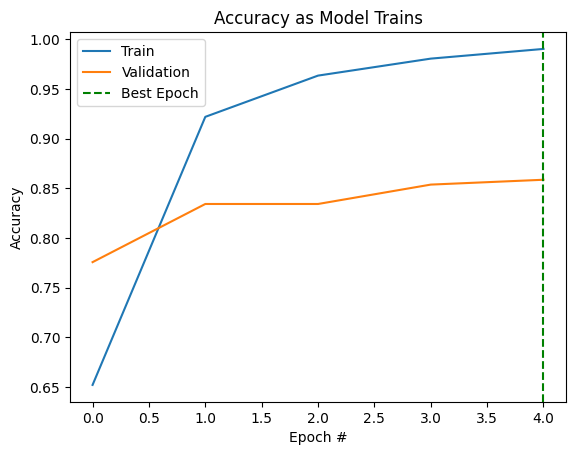

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


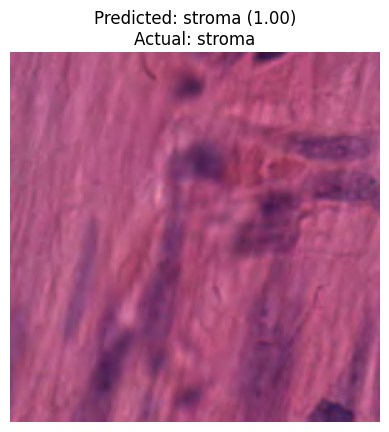

In [ ]:
# @title # **Fitting the Model and Plotting It**
# Fit model
one_hot_encoding_to_label_dict = {np.argmax(ohe):label for ohe, label in zip(labels_ohe, labels)}

def ScoreVectorToPredictions(prob_vector):
    class_num = np.argmax(prob_vector)
    class_name = one_hot_encoding_to_label_dict[class_num]
    return class_name, max(prob_vector)


history = transfer_cnn.fit(X_train_resized, y_train, epochs=5, validation_data=(X_test_resized, y_test))
plot_metric(history)


# Pick an index (e.g., the 5th image in the test set)
i = 5

# Get the input image
img = X_test_resized[i]

# Predict the probabilities
prob_vector = transfer_cnn.predict(np.expand_dims(img, axis=0))[0]

# Get predicted class and probability
class_name, confidence = ScoreVectorToPredictions(prob_vector)

# Get actual label
actual_class = ScoreVectorToPredictions(y_test[i])[0]

# Show the image
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_name} ({confidence:.2f})\nActual: {actual_class}")
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
predicted labels: [np.str_('complex'), np.str_('complex'), np.str_('complex'), np.str_('empty'), np.str_('empty'), np.str_('stroma'), np.str_('lympho'), np.str_('lympho'), np.str_('mucosa'), np.str_('mucosa'), np.str_('mucosa'), np.str_('mucosa'), np.str_('adipose'), np.str_('empty'), np.str_('complex'), np.str_('tumor'), np.str_('complex'), np.str_('tumor'), np.str_('mucosa'), np.str_('lympho'), np.str_('adipose'), np.str_('lympho'), np.str_('lympho'), np.str_('complex'), np.str_('adipose'), np.str_('stroma'), np.str_('mucosa'), np.str_('tumor'), np.str_('adipose'), np.str_('stroma'), np.str_('mucosa'), np.str_('adipose'), np.str_('lympho'), np.str_('empty'), np.str_('empty'), np.str_('adipose'), np.str_('stroma'), np.str_('mucosa'), np.str_('empty'), np.str_('adipose'), np.str_('empty'), np.str_('empty'), np.str_('lympho'), np.str_('mucosa'), np.str_('empty'), np.str_('mucosa'), np.str_('debris'), np.str_('stroma'), np.str_('adipose'), np.str_('tu

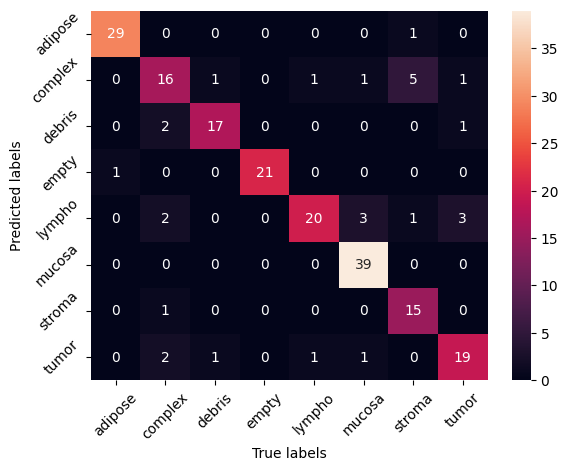

In [ ]:
# @title # **Making the Confusion Matrix**
# one-hot to label map
one_hot_encoding_to_label_dict = {np.argmax(ohe): label for ohe, label in zip(labels_ohe, labels)}


# Predict
y_pred_probs = transfer_cnn.predict(X_test_resized, batch_size=32)
y_pred_labels = [ScoreVectorToPredictions(y)[0] for y in y_pred_probs]
print('predicted labels:', y_pred_labels)

# True labels from one-hot test labels
y_test_labels = [ScoreVectorToPredictions(y)[0] for y in y_test]
print('actual labels:', y_test_labels)

# Confusion matrix
ConfusionMatrix(y_test_labels, y_pred_labels)
